In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.insert(0,"../")

from src.kernel import VFTSGaussKernel,TSGaussGaussKernel
from src.loss import SumVarifoldLoss
from src.lddmm import Shooting,Flowing

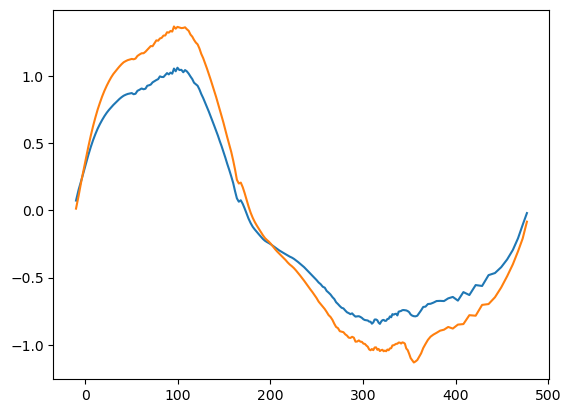

In [3]:
np.random.seed(0)

y =pd.read_csv("../datasets/Mouse/y_600.csv",index_col=0)
X = np.load("../datasets/Mouse/X_600.npy")
X_mask = np.load("../datasets/Mouse/X_600_mask.npy")
idxs = np.load("./results/ts-lddmm_exp_2/idxs.npy")
X,X_mask = X[idxs],X_mask[idxs]
X,X_mask = X[:,::2,:],X_mask[:,::2,:]
y = y.iloc[idxs]



p0s = np.load("./results/ts-lddmm_exp_2/p0s.npy")
q0 = np.load("./results/ts-lddmm_exp_2/q0.npy")
q0_mask = np.load("./results/ts-lddmm_exp_2/q0_mask.npy")
p0s = p0s.reshape(-1,p0s.shape[2],p0s.shape[3])
plt.plot(q0[q0_mask.squeeze(),0],q0[q0_mask.squeeze(),1])
plt.plot(q0[q0_mask.squeeze(),0],q0[q0_mask.squeeze(),2])

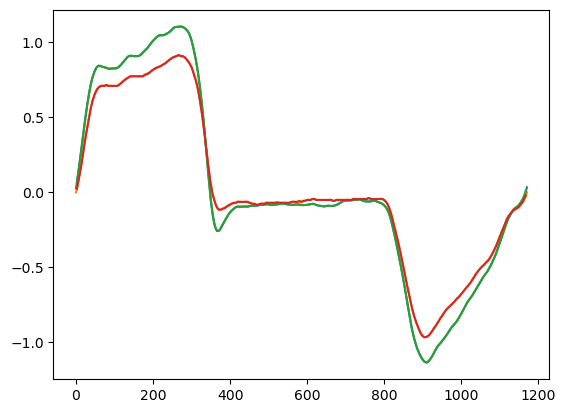

In [4]:
Kv = VFTSGaussKernel(1,0.1,150,1,2)
Kl0 = TSGaussGaussKernel(30,2,30,1)
Kl1 = TSGaussGaussKernel(5,2,5,1)
Kl2 = TSGaussGaussKernel(2,1,2,0.6)
Kl3 = TSGaussGaussKernel(1,0.1,1,0.1)
Kls=[Kl0,Kl1,Kl2,Kl3]
dataloss = SumVarifoldLoss(Kls)

shoot = Shooting(Kv)
flow = Flowing(Kv)
idx = -10
p,q = shoot(p0s[idx],q0,q0_mask)
x = X[idx][X_mask[idx].squeeze()]
qp = q[q0_mask.squeeze()]
plt.plot(x[:,0],x[:,1],)
plt.plot(x[:,0],x[:,2])
plt.plot(qp[:,0],qp[:,1])
plt.plot(qp[:,0],qp[:,2])

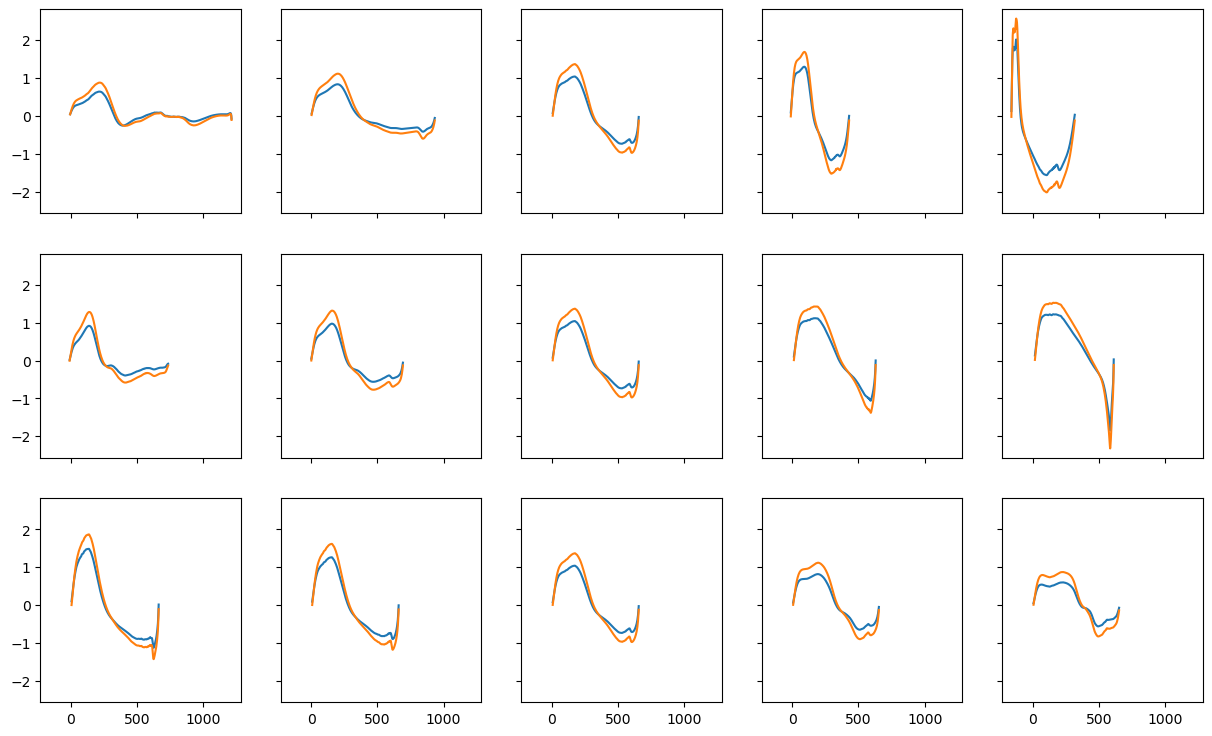

In [5]:
from src.statistic import MomentaPCA
n_comp,n_disp = 3,5
mpca = MomentaPCA(n_comp,False,"cov")
mpca.fit(Kv,p0s,q0,q0_mask)

p0_bar = mpca.m_ps_
plot_mask = np.where(q0_mask==True)[0]
k = 1
shoot = Shooting(Kv)
p0_b = mpca.m_ps_
fig,axs = plt.subplots(n_comp,n_disp,figsize = (n_disp*3,n_comp*3),sharex=True,sharey=True)
for pca_index in range(n_comp):
    sigma_pca = mpca.p_std_[pca_index]
    for j,alpha in enumerate(np.linspace(-2*sigma_pca , 2*sigma_pca, n_disp)):
        p0_mode = p0_b + alpha * mpca.p_pc_[pca_index]
        _,q = shoot(p0_mode,q0,q0_mask)
        plot_q = q[plot_mask].T
        axs[pca_index,j].plot(plot_q[0],plot_q[1])
        axs[pca_index,j].plot(plot_q[0],plot_q[2])

/tmp/ipykernel_1070120/3891157674.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[11.442275    6.13283333  3.28498333 ... 23.87848333 47.568375
 41.32665833]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tdf.loc[:,"start"] /= (2000.*60.)


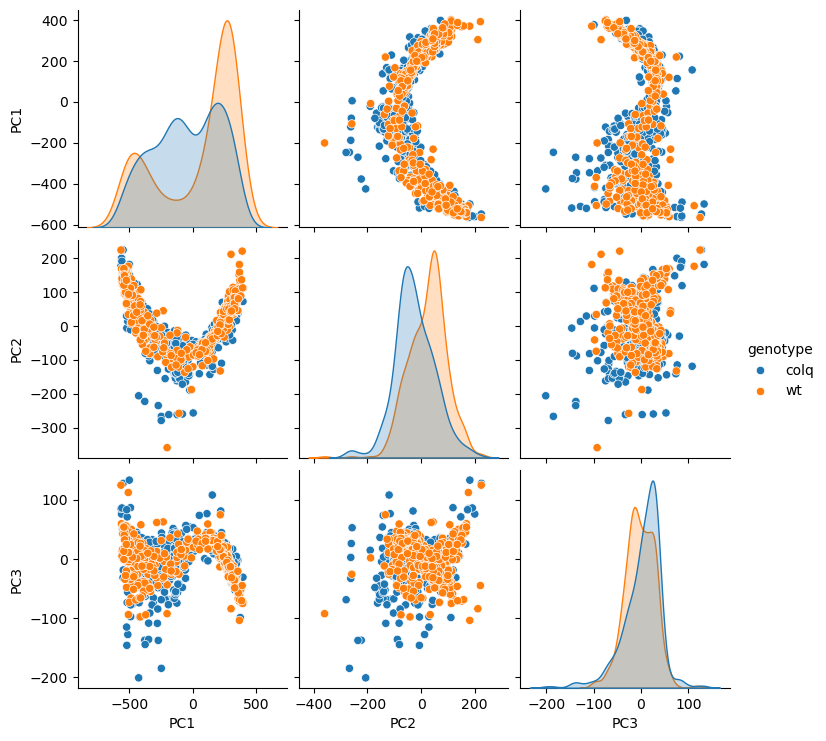

In [6]:
df = y.copy()
filenames = df.filename.unique()

def create_mapping(filenames): 
    dct = {}
    count_colq = 1
    count_wt = 1
    for filename in filenames: 
        if "colq" in filename: 
            dct[filename] = f"colq_{count_colq}"
            count_colq +=1
        elif "wt" in filename: 
            dct[filename] = f"wt_{count_wt}"
            count_wt +=1
    return dct

mapping_dct = create_mapping(filenames)
df["mouse_id"] = df.filename.apply(lambda x :mapping_dct[x])



df[[f"PC{i+1}" for i in range(n_comp)]] = mpca.p_score_
tdf = df[["start","before"]]
max_before = tdf[tdf.before == "Y"].start.max()
tdf.loc[tdf.before == "N","start"] = tdf[tdf.before == "N"].start.copy().values + max_before
tdf.loc[:,"start"] /= (2000.*60.)
df["time"] = tdf.start
df
sns.pairplot(df,hue = "genotype",vars=[f"PC{i+1}" for i in range(n_comp)])

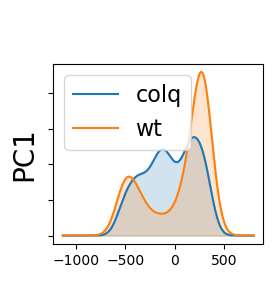

In [14]:
from scipy.stats import gaussian_kde
color_mapping ={"colq": "tab:blue", "wt" : "tab:orange"}
components = [f"PC{i+1}" for i in range(n_comp)]
span =1.0
nsample = 10000
ft_size = 20
pft_size = 16



fig,ax = plt.subplots(nrows=1,ncols=1, figsize = (3,3))
r = df["PC1"].values.max()
l = df["PC1"].values.min()
x = np.linspace(l -np.abs(span*l),r +np.abs(span*r),nsample)
for gen,color in color_mapping.items(): 
    arr = df[df.genotype == gen]["PC1"].values
    y = gaussian_kde(arr)(x)
    ax.plot(x,y,color=color,label=gen)
    ax.fill_between(x,y,color=color,alpha=0.2)
    ax.set_ylabel("PC1",fontsize=ft_size)

ax.set_yticklabels([])
#ax.set_xticklabels([])
ax.legend(fontsize=pft_size)
#ax.set_title("A) PC density",fontsize=ft_size)
ax.set_xlabel(" ",fontsize=pft_size)
fig.suptitle(" ",fontsize=ft_size)
plt.subplots_adjust(left=0.2,bottom=0.2,right=0.9,top=0.8,wspace=0.1,hspace=0.1)
fig.savefig("./figures/ts-lddmm_exp_2_density.svg",format="svg")

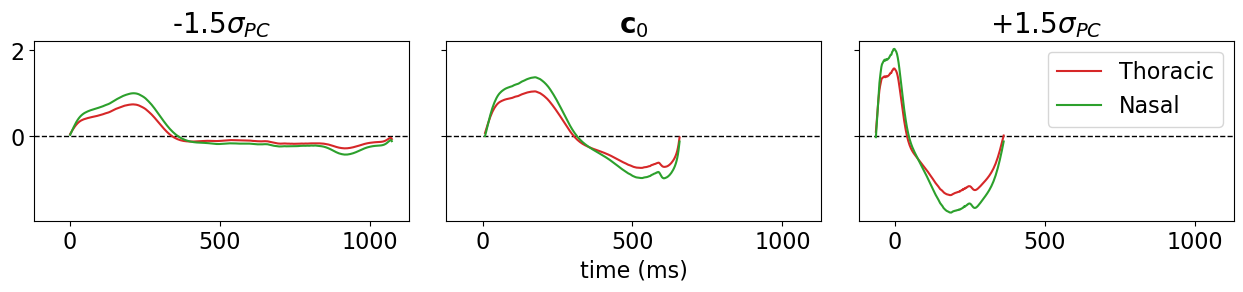

In [8]:
from src.statistic import MomentaPCA
ncomp,ndisp = 1,3
mpca = MomentaPCA(ncomp)
mpca.fit(Kv,p0s,q0,q0_mask)

p0_bar = mpca.m_ps_
k = 1

fig,axs = plt.subplots(ncomp,ndisp,figsize = (ndisp*5,3),sharex=True,sharey=True)
sigma_pca = np.std(mpca.p_score_[:,0])
for j,alpha in enumerate(np.array([-1.5,0,1.5])*sigma_pca):
    p0_mode = p0_bar + alpha * mpca.p_pc_[0]
    p,q = shoot(p0_mode,q0,q0_mask)
    q = q[q0_mask.squeeze()]
    axs[j].plot(q[:,0],q[:,1],color="tab:red",label="Thoracic")
    axs[j].plot(q[:,0],q[:,2],color="tab:green",label="Nasal")
       

for ax in axs.flatten():
    ax.axhline(0,color="black",linewidth=1,linestyle="--",zorder=0)

axs[1].set_xlabel("time (ms)",fontsize=pft_size)

axs[0].set_title(r"-1.5$\sigma_{PC}$",fontsize=ft_size)
axs[1].set_title(r"$\mathbf{c}_0$",fontsize=ft_size)
axs[2].set_title(r"+1.5$\sigma_{PC}$",fontsize=ft_size)
axs[2].legend(fontsize = pft_size)
for ax in axs:
    ax.xaxis.set_tick_params(labelsize=pft_size)
for ax in axs:
    ax.yaxis.set_tick_params(labelsize=pft_size)

#fig.suptitle("B) PC shootings",fontsize = ft_size)

plt.subplots_adjust(left=0.1,bottom=0.2,right=0.9,top=0.8,wspace=0.1,hspace=0.1)
fig.savefig("./figures/ts-lddmm_exp_2_shooting.svg",format="svg")


/tmp/ipykernel_1070120/2927743001.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('plasma')
/tmp/ipykernel_1070120/2927743001.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(ticklabs, fontsize=pft_size)


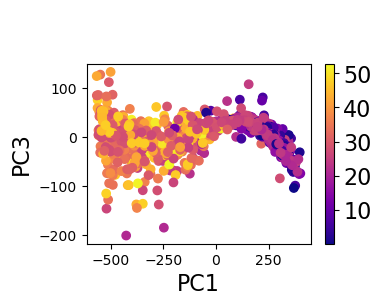

In [12]:
fig,ax = plt.subplots(nrows=1,ncols=1, figsize = (4,3))
x = df.PC1.values
y = df.PC3.values
c = df.time.values
cm = plt.cm.get_cmap('plasma')
sc = ax.scatter(x,y,c=c,cmap = cm)
cbar = fig.colorbar(sc)
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs, fontsize=pft_size)
    

#ax.set_yticklabels([])
#ax.set_xticklabels([])
#ax.xaxis.set_tick_params(labelsize=pft_size)
#ax.yaxis.set_tick_params(labelsize=pft_size)
#ax.set_title("C) PC1/PC3 time",fontsize=ft_size)
ax.set_ylabel("PC3",fontsize=pft_size)
ax.set_xlabel("PC1",fontsize=pft_size)
fig.suptitle(" ",fontsize=ft_size)
plt.subplots_adjust(left=0.2,bottom=0.2,right=0.9,top=0.8,wspace=0.1,hspace=0.1)
fig.savefig("./figures/ts_lddmm_exp_2_time.svg",format="svg")